In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf

import utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
DATA_DIRNAME = Path('/home/saurabh/Documents/dev_2/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

print('Number of samples:', len(crop_filenames))

NUM_LABELS = 2
RESIZE_SCALE_FACTOR = 0.5

X = []
Y = []
for ind in range(len(crop_filenames)):
    name = crop_filenames[ind].stem
    image = cv2.imread(str(crop_filenames[ind]), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)
    
    # only have three labels: background, odd lines, even lines
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1
    
    # get rid of even lines
    gt_image[gt_image == 2] = 0
    
    image = cv2.resize(image, dsize=None, fx=RESIZE_SCALE_FACTOR, fy=RESIZE_SCALE_FACTOR)
    gt_image = cv2.resize(gt_image, dsize=None, fx=RESIZE_SCALE_FACTOR, fy=RESIZE_SCALE_FACTOR, 
                          interpolation=cv2.INTER_NEAREST)
    
#     X.append(image / 255)
#     Y.append(to_categorical(gt_image.flatten(), NUM_LABELS))
    X.append(1. - image / 255.)
    Y.append(gt_image.flatten())


X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# For training
X_train = X[:1000]
X_test = X[1000:]
Y_train = Y[:1000]
Y_test = Y[1000:]

# For overfitting
# X_single = np.repeat(X[0:1], X.shape[0], axis=0)
# Y_single = np.repeat(Y[0:1], Y.shape[0], axis=0)

Number of samples: 1537
(1537, 316, 310) float32 (1537, 97960) uint8


In [3]:
def plot(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap='gray', vmin=0, vmax=max(1, image.max()))
    plt.colorbar()

def hplot(x, y, y_pred=None, title=''):
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(title)
    ax1 = fig.add_subplot(131)
    ax1.imshow(x, cmap='gray', vmin=0, vmax=1)
    ax2 = fig.add_subplot(132)
    ax2.imshow(y.reshape(x.shape), cmap='gray', vmin=0, vmax=1)
    if y_pred is not None:
        ax3 = fig.add_subplot(133)
        ax3.imshow(y_pred.reshape(x.shape), cmap='gray', vmin=0, vmax=1)

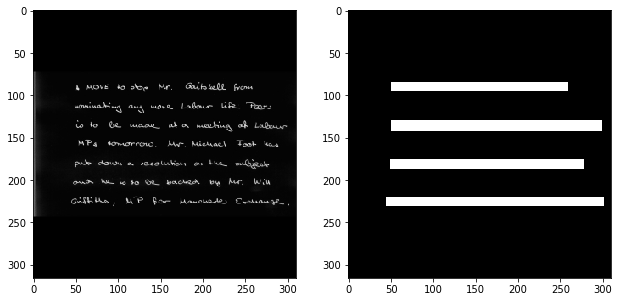

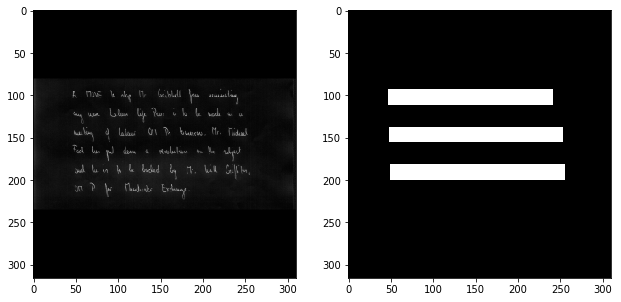

In [ ]:
hplot(X[0], Y[0])
hplot(X[1], Y[1])

In [ ]:
MAX_HEIGHT, MAX_WIDTH = X.shape[1:]
MAX_HEIGHT, MAX_WIDTH

(316, 310)

In [ ]:
base_model_dirname = './_models'
!mkdir -p {base_model_dirname}

identifier = utils.generate_unique_identifier(dirname_with_identifiers=base_model_dirname)
model_dirname = f'{base_model_dirname}/{identifier}'
checkpoints_dirname = f'{model_dirname}/_checkpoints'

!mkdir {model_dirname}
!mkdir {checkpoints_dirname}

model_dirname

'./_models/csrkg5zi'

In [ ]:
# This is a DenseNet-y kind of network, with dilation used to increase receptive field.
K.clear_session()  

def conv_block(inputs, num_filters, kernel_size, dilation_rate, activation, batch_norm=False):
    conv = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, 
                  use_bias=(not batch_norm), padding='same')(inputs)
    if batch_norm:
        conv = BatchNormalization()(conv)
    return Activation(activation)(conv)


input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_reshaped = Reshape((MAX_HEIGHT, MAX_WIDTH, 1))(input_image)

conv = conv_block(input_image_reshaped, 16, 7, 3, 'relu')
conv = conv_block(conv, 16, 7, 3, 'relu')
conv = conv_block(conv, 16, 7, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
conv = conv_block(conv, 16, 5, 3, 'relu')
output = conv_block(conv, 1, 1, 1, 'sigmoid')

output = Flatten()(output)
model = Model(inputs=input_image, outputs=output)
model.summary()

model.compile(optimizer=Adam(0.001/2), loss='categorical_crossentropy')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25),
    ModelCheckpoint(
            filepath=checkpoints_dirname + "/epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5",
            monitor='val_loss',
            save_best_only=True
        )
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 316, 310)          0         
_________________________________________________________________
reshape (Reshape)            (None, 316, 310, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 316, 310, 16)      800       
_________________________________________________________________
activation (Activation)      (None, 316, 310, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 316, 310, 16)      12560     
_________________________________________________________________
activation_1 (Activation)    (None, 316, 310, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 316, 310, 16)      12560     
__________

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, Y_test),
    shuffle=True,
    callbacks=callbacks
)

Train on 1000 samples, validate on 537 samples
Epoch 1/1000
1000/1000 [==============================] - 23s 23ms/step - loss: 168725.2176 - val_loss: 167047.1248
Epoch 2/1000
1000/1000 [==============================] - 20s 20ms/step - loss: 161917.6182 - val_loss: 160406.0271
Epoch 3/1000
 576/1000 [================>.............] - ETA: 6s - loss: 159578.6372

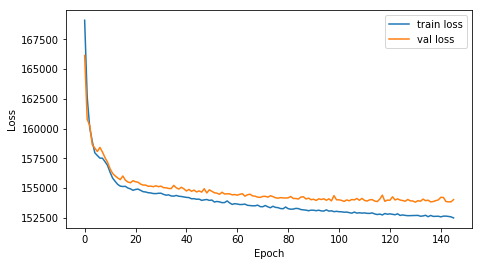

In [53]:
utils.plot_training_history(history.history, metric=None)

In [45]:
model.evaluate(X_test, Y_test, batch_size=16)

537/537 [==============================] - 4s 7ms/step


154018.8282122905

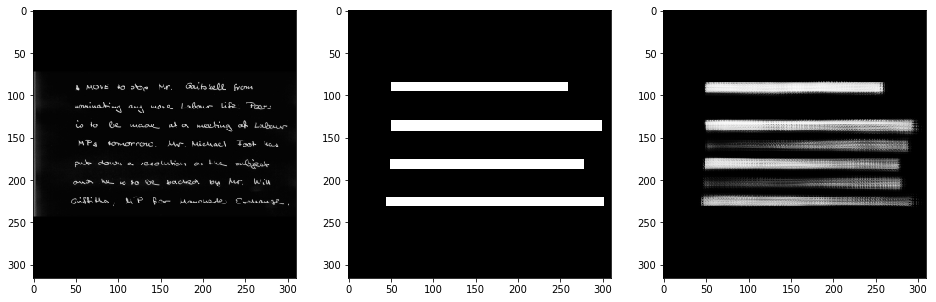

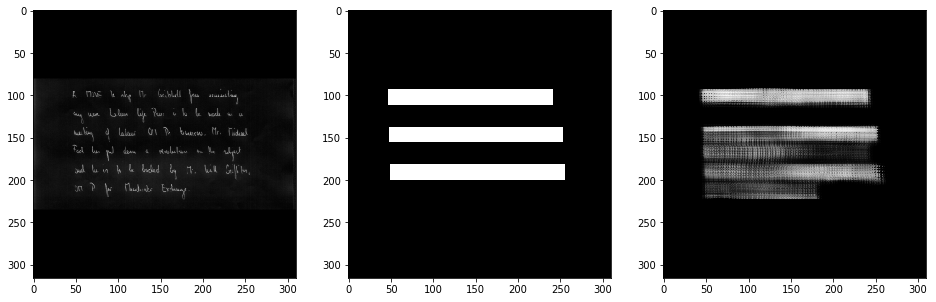

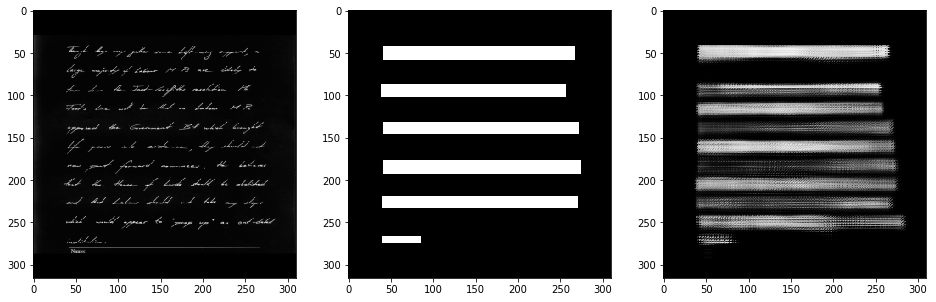

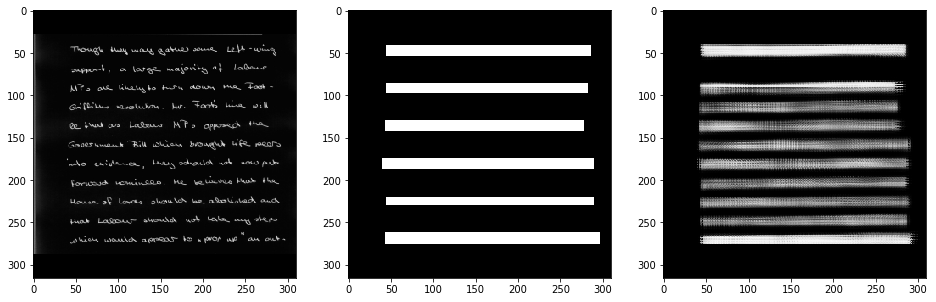

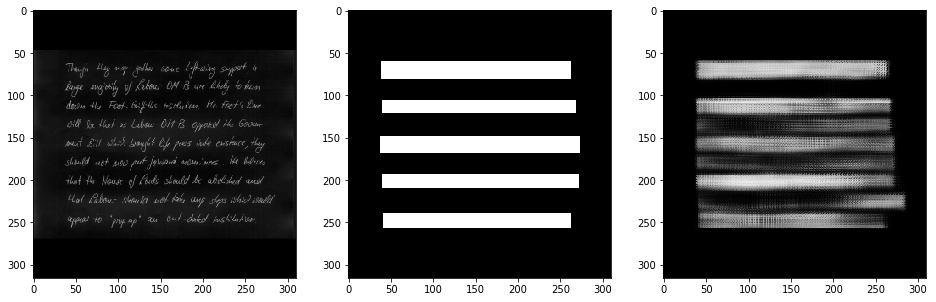

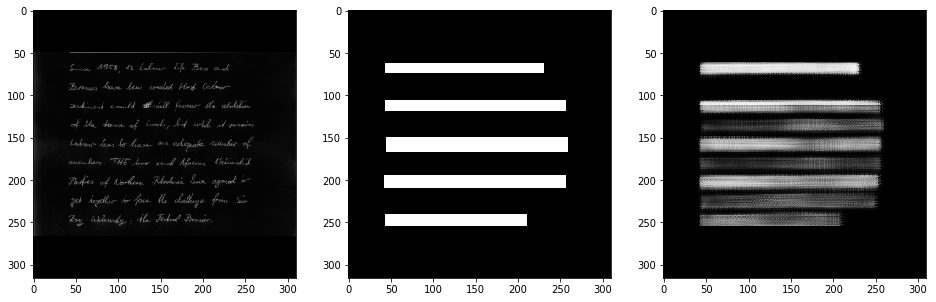

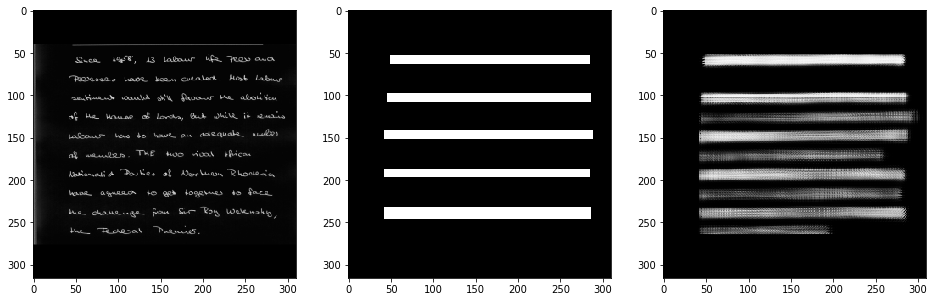

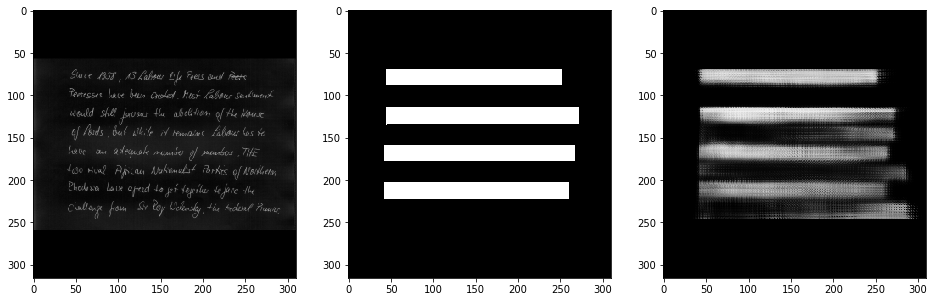

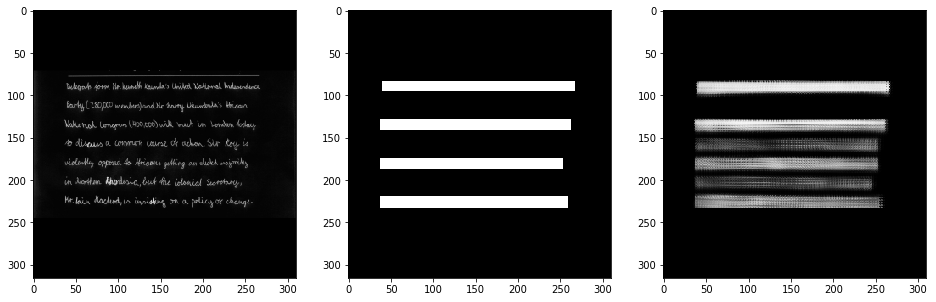

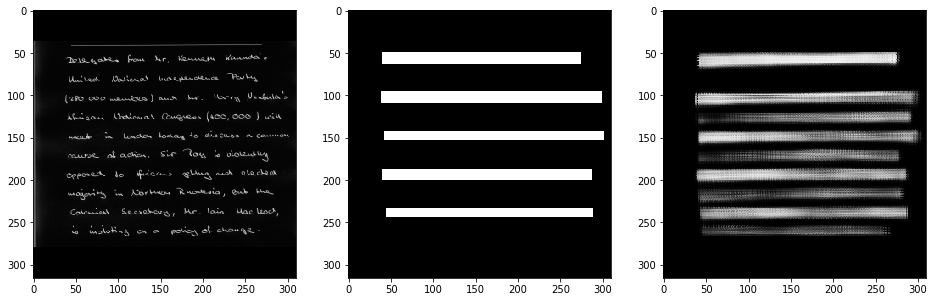

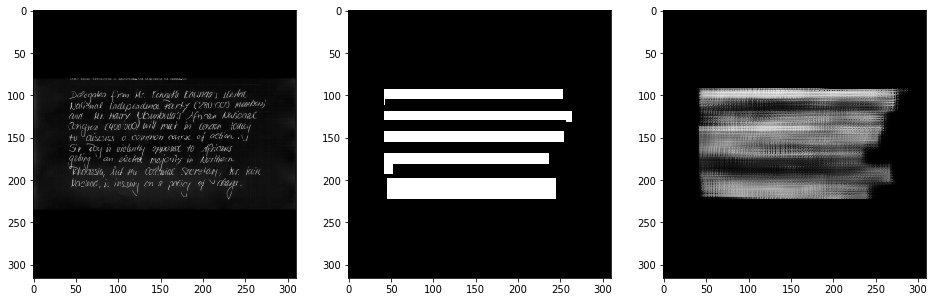

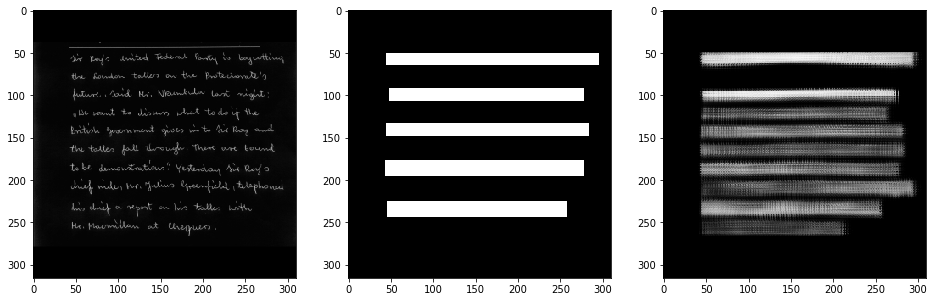

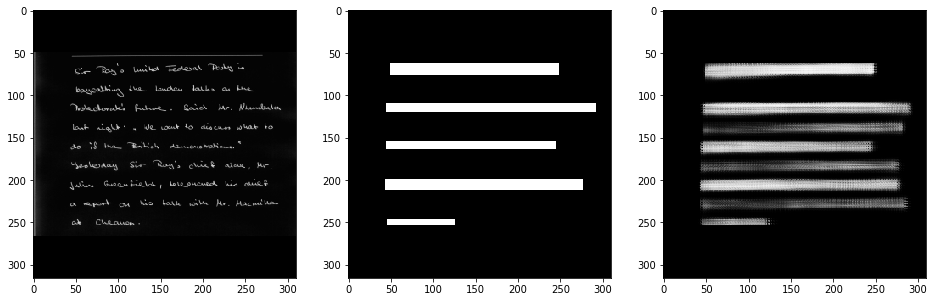

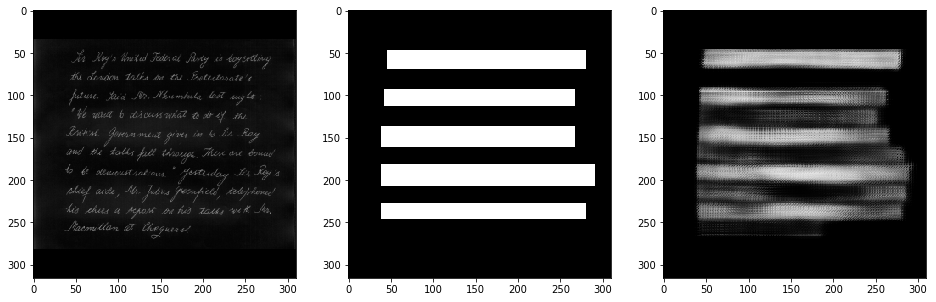

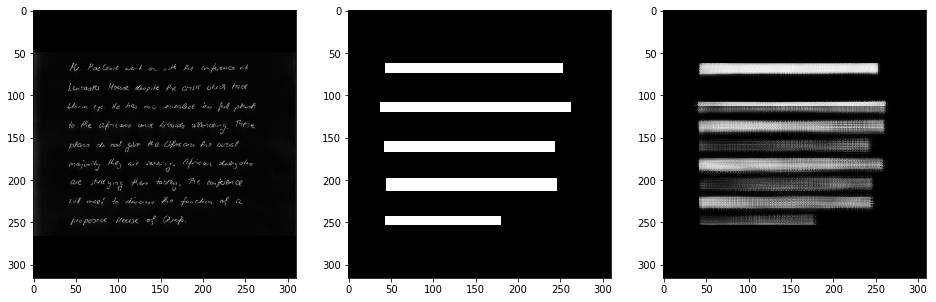

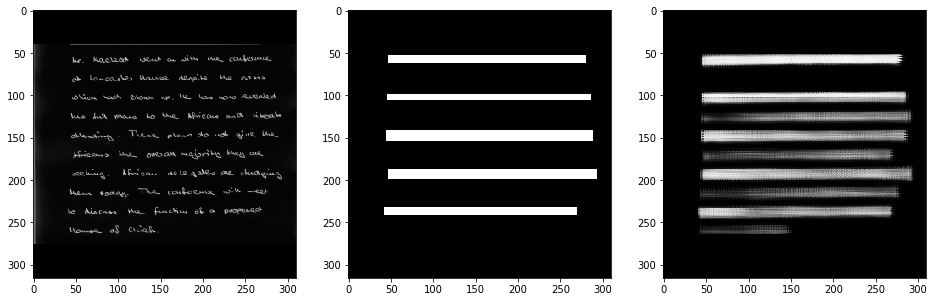

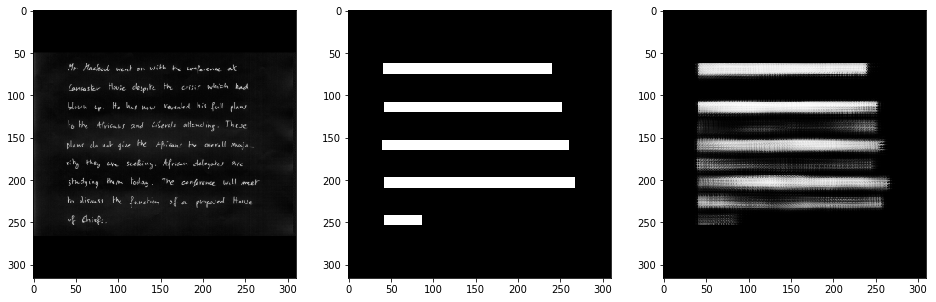

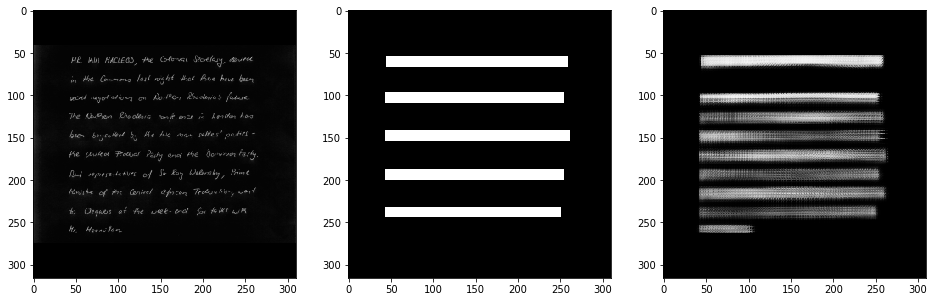

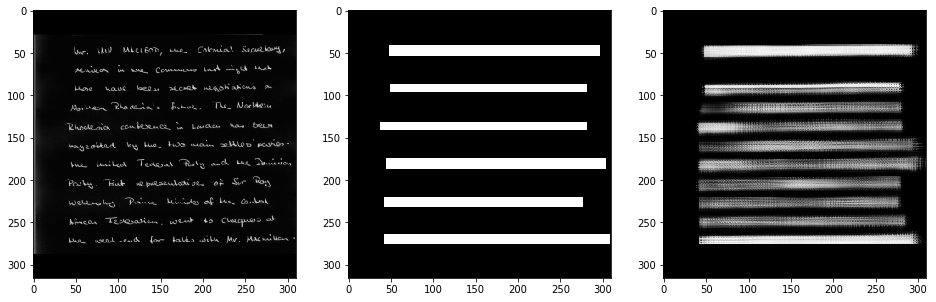

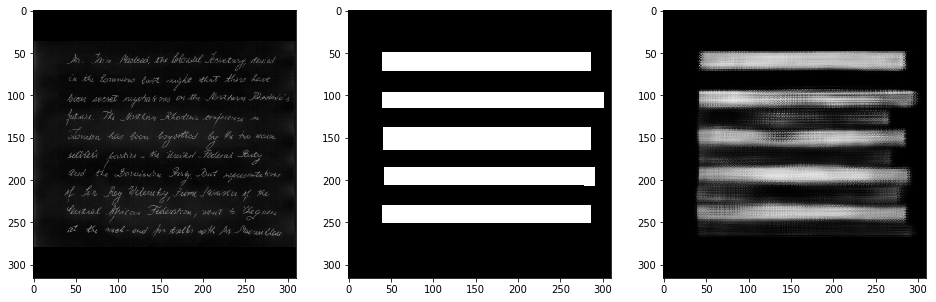

In [46]:
start_id = 0
count = 20

for x, y in zip(X_train[start_id:start_id+count], Y_train[start_id:start_id+count]):
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    hplot(x, y, y_pred)

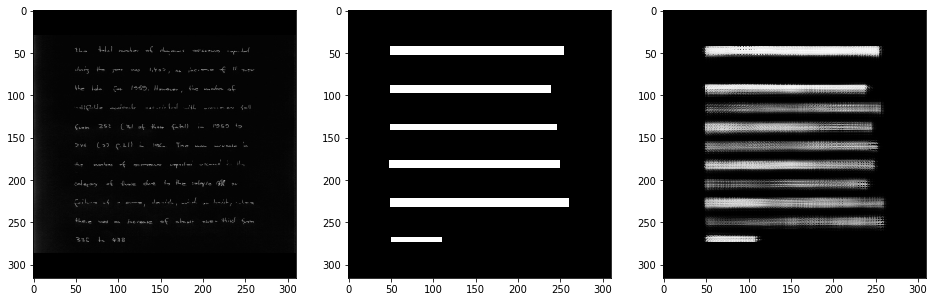

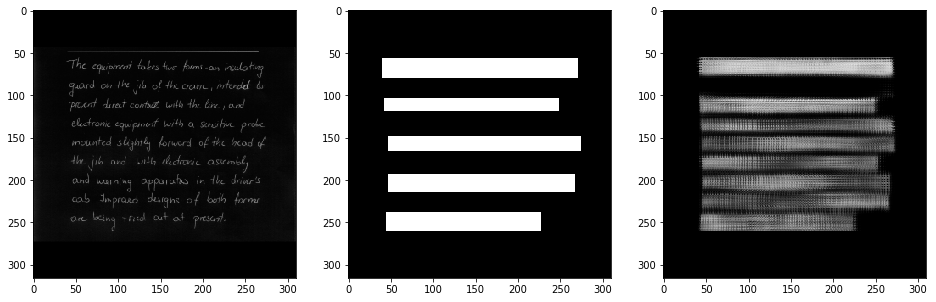

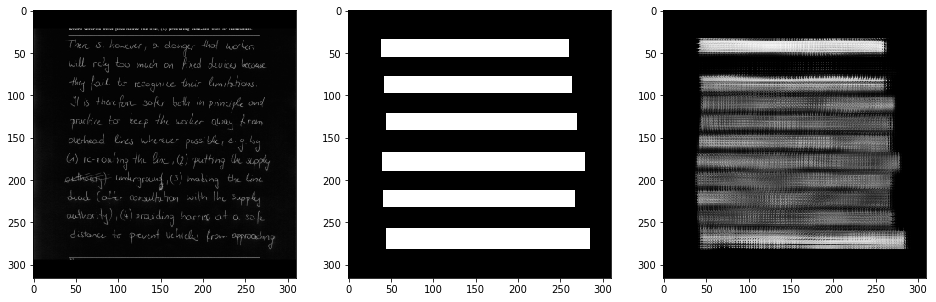

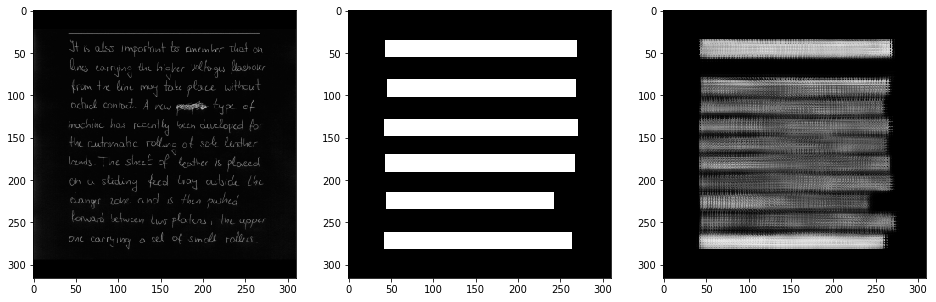

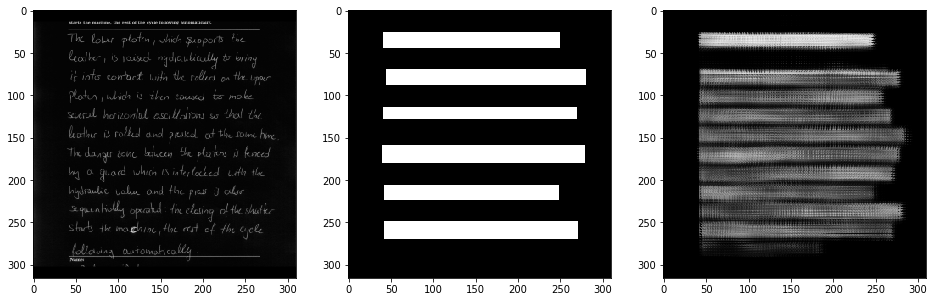

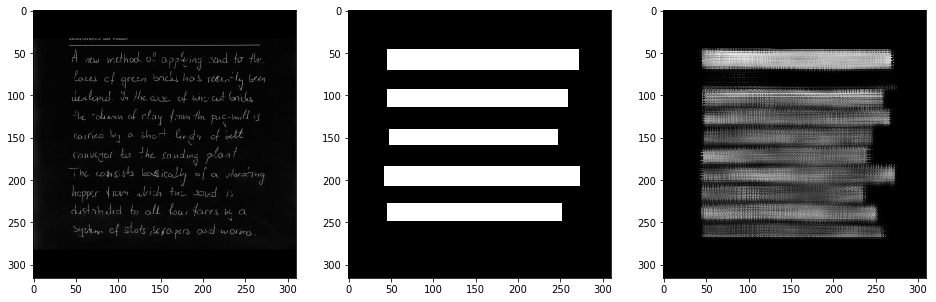

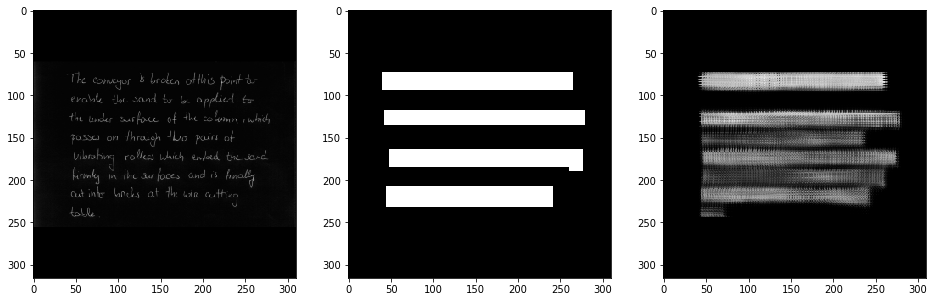

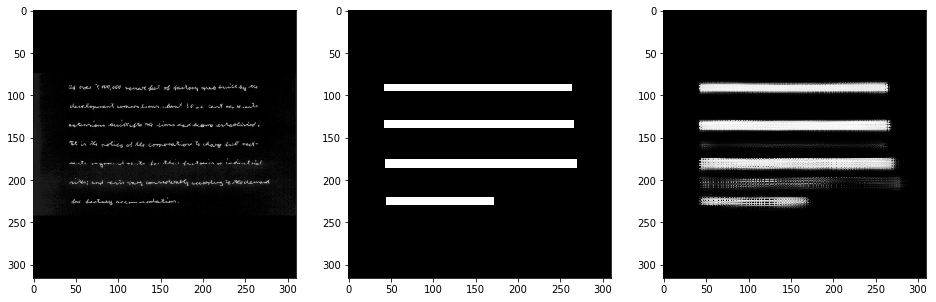

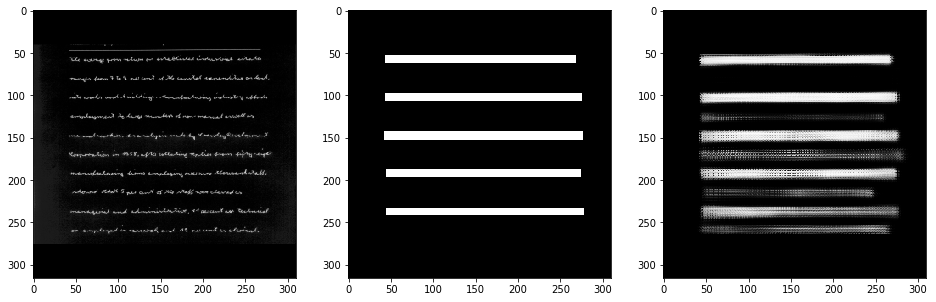

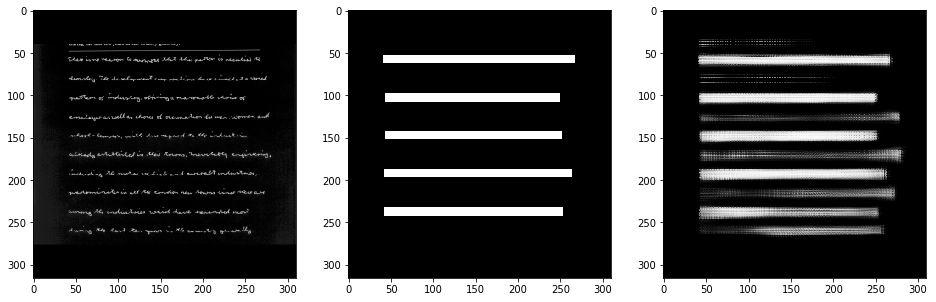

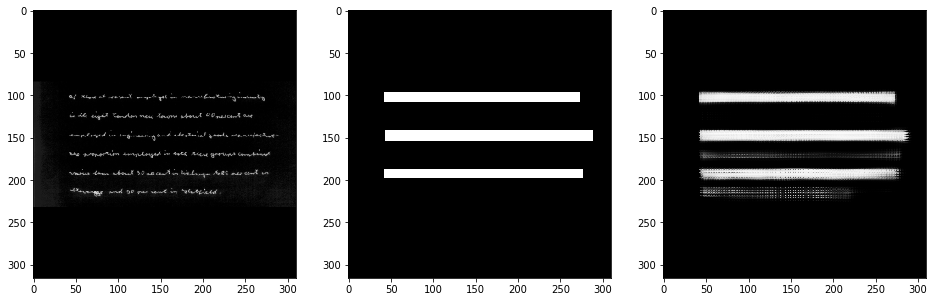

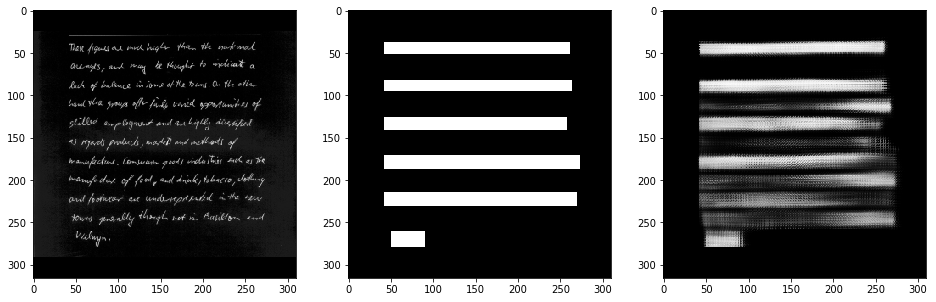

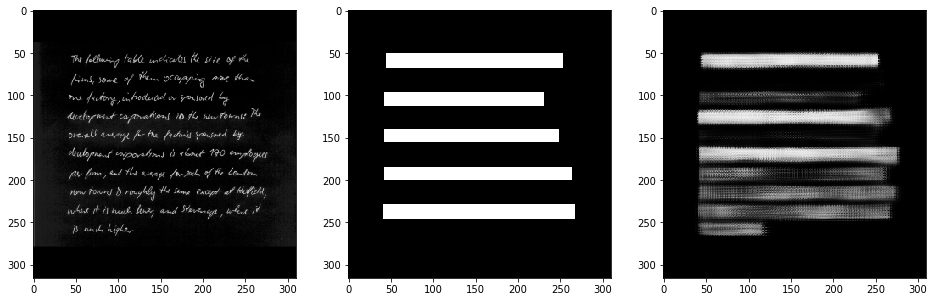

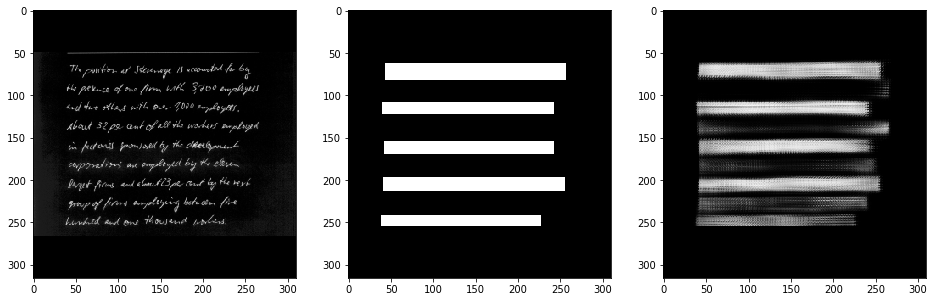

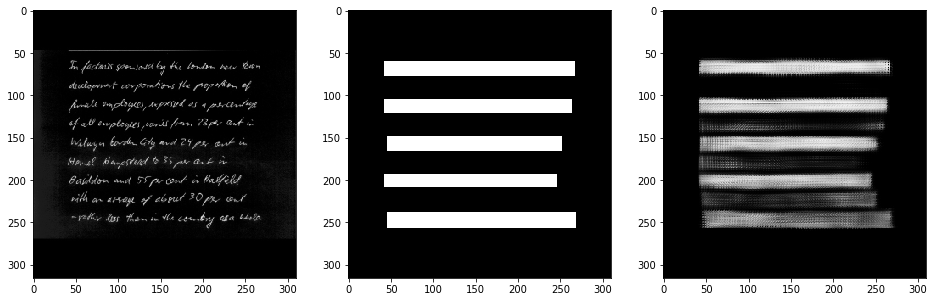

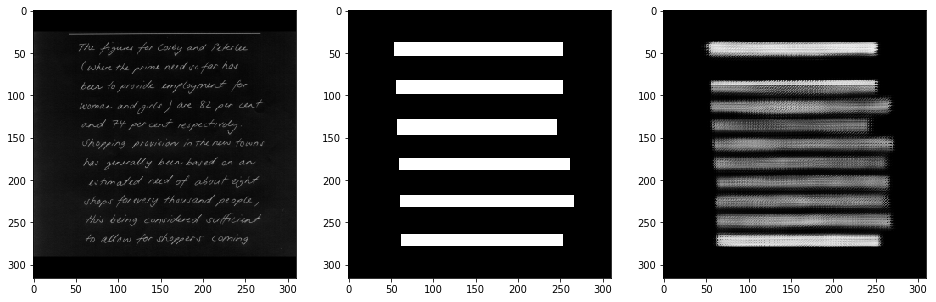

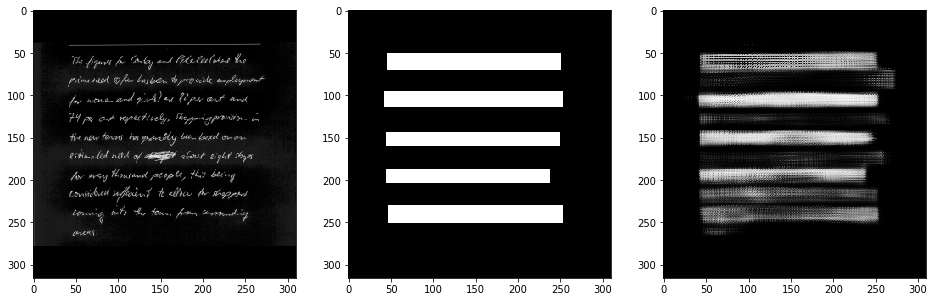

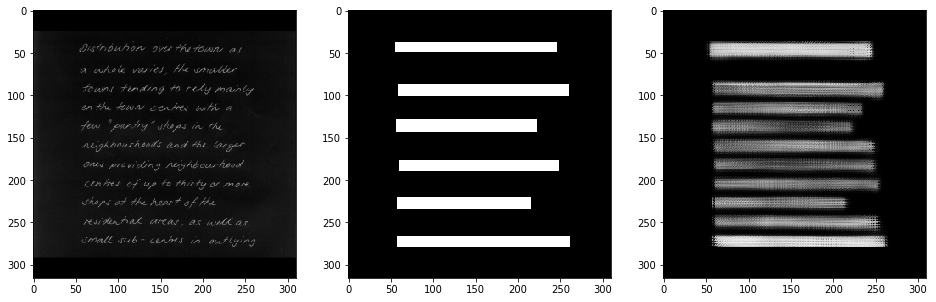

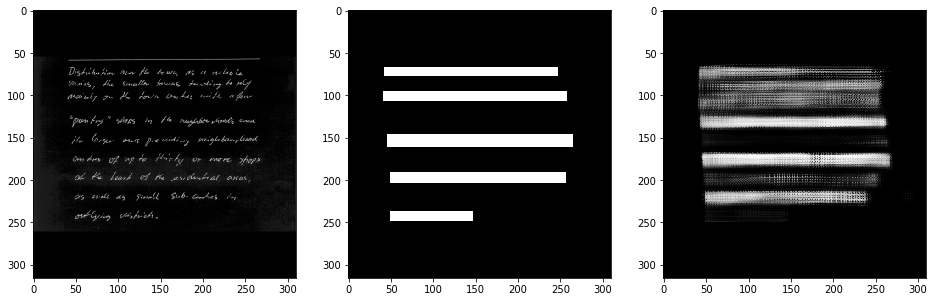

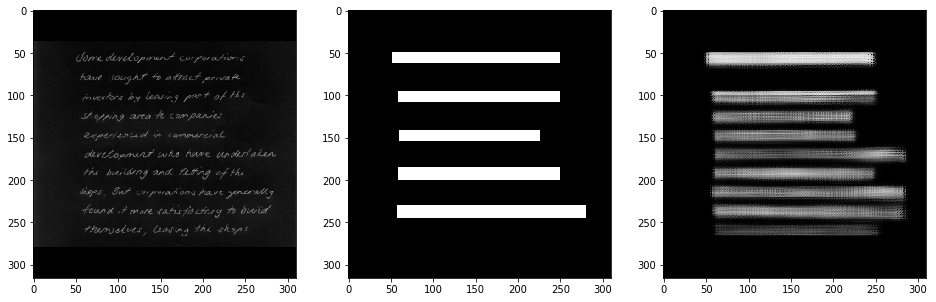

In [47]:
start_id = 0
count = 20

for x, y in zip(X_test[start_id:start_id+count], Y_test[start_id:start_id+count]):
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    hplot(x, y, y_pred, )